In [43]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

from sklearn.model_selection import StratifiedKFold

import cv2

import sys
sys.path.append('./home/facebook-detr-files/')
from models.matcher import HungarianMatcher
from models.detr import SetCriterion

import albumentations as T
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob

In [45]:
n_folds = 5
seed = 42
num_classes = 2# wheat pods and everything else
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 20

In [46]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(seed)

In [48]:
# Creating Folds

bounding_boxes = pd.read_csv('./home/global-wheat-detection/train.csv')
bboxs = np.stack(bounding_boxes['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    bounding_boxes[column] = bboxs[:,i]
bounding_boxes.drop(columns=['bbox'], inplace=True)

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [49]:
def get_train_transforms():
    import albumentations as T

    return T.Compose([T.OneOf(
        [T.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                               
                      T.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],
        p=0.9),
                      
                     
                      T.Rotate(limit=180),
                      
                      T.HorizontalFlip(p=0.5),
                      
                      T.VerticalFlip(p=0.5),
                      
                      T.Resize(height=512, width=512, p=1),
                      
                      T.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
                      
                      T.pytorch.transforms.ToTensorV2(p=1.0)],
                      
                      p=1.0,
                     
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      T.pytorch.transforms.ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

In [50]:
DIR_TRAIN = './home/nizamphoenix/global-wheat-detection/train'
class WheatDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes coco format 
        boxes = records[['x', 'y', 'w', 'h']].values
        
        #Area of bounding boxes
        area = torch.as_tensor(boxes[:,2]*boxes[:,3], dtype=torch.float32)
        
        # Works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)

        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
            
        #Normalizing BBOXES
            
        _,h,w = image.shape
        boxes = T.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

In [51]:
class DETRModel(nn.Module):
    '''
    Simple model with ResNet50 as backbone
    '''
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

In [52]:

matcher = HungarianMatcher()
weight_dict  = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
losses = ['labels', 'boxes', 'cardinality']

class MetricsOperation(object):
    """Class to regularly update metrics and losses"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [53]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    '''
    We train the criterion and the model
    '''
    model.train()
    criterion.train()#we train the criterion--bipartite matching loss-- as well, which is the reason for performing better than  Faster R-CNN
    summary_loss = MetricsOperation()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

In [54]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = MetricsOperation()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

In [56]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run(fold):
    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    train_dataset = WheatDataset(
    image_ids=df_train.index.values,
    dataframe=marking,
    transforms=get_train_transforms()
    )

    valid_dataset = WheatDataset(
    image_ids=df_valid.index.values,
    dataframe=marking,
    transforms=get_valid_transforms()
    )
    
    train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    best_loss = 10**5
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')

In [58]:
run(fold=3)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master



|EPOCH 1| TRAIN_LOSS 1.4048321024906| VALID_LOSS 1.054905634767869|
Best model found for Fold 3 in Epoch 1........Saving Model



|EPOCH 2| TRAIN_LOSS 1.0901959547277034| VALID_LOSS 0.9784263442544376|
Best model found for Fold 3 in Epoch 2........Saving Model


In [85]:
def view_sample(df_valid,model,device):
    '''
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    valid_dataset = WheatDataset(image_ids=df_valid.index.values,
                                 dataframe=marking,
                                 transforms=get_valid_transforms()
                                )
     
    valid_data_loader = DataLoader(
                                    valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                   num_workers=4,
                                   collate_fn=collate_fn)
    
    images, targets, image_ids = next(iter(valid_data_loader))
    _,h,w = images[0].shape # for de normalizing images
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in T.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        RED = (255, 0, 0)# Ground truth
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  RED, 1)
        

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in T.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    
    for box,p in zip(oboxes,prob):
        if p >0.5:
            BLUE = (0,0,255)# predictions
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  BLUE, 1)
    
    ax.set_axis_off()
    ax.imshow(sample)
    plt.title('Blue are predictions, Red are ground truths')

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


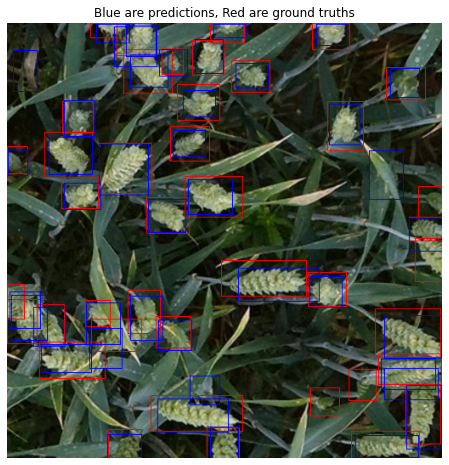

In [87]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("./detr_best_0.pth"))
m=view_sample(df_folds[df_folds['fold'] == 0],model,device=torch.device('cuda'))

## Creating ensemble from all folds using Weighted Box Fusion  
Code for WBF is adapted from [this source](https://github.com/ZFTurbo/Weighted-Boxes-Fusion)  

In [ ]:
# models = []
# model = DETRModel(num_classes=num_classes,num_queries=num_queries)
# models.append(model.load_state_dict(torch.load("./detr_best_0.pth")))
# models.append(model.load_state_dict(torch.load("./detr_best_1.pth")))
# models.append(model.load_state_dict(torch.load("./detr_best_3.pth")))

In [73]:
import numpy as np


def bb_intersection_over_union(A, B):
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def prefilter_boxes(boxes, scores, labels, weights, thr):
    # Create dict with boxes stored by its label
    new_boxes = dict()
    for t in range(len(boxes)):
        for j in range(len(boxes[t])):
            label = int(labels[t][j])
            score = scores[t][j]
            if score < thr:
                break
            box_part = boxes[t][j]
            b = [int(label), float(score) * weights[t], float(box_part[0]), float(box_part[1]), float(box_part[2]), float(box_part[3])]
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

    # Sort each list in dict and transform it to numpy array
    for k in new_boxes:
        current_boxes = np.array(new_boxes[k])
        new_boxes[k] = current_boxes[current_boxes[:, 1].argsort()[::-1]]

    return new_boxes


def get_weighted_box(boxes, conf_type='avg'):
    """
    Create weighted box for set of boxes
    :param boxes: set of boxes to fuse 
    :param conf_type: type of confidence one of 'avg' or 'max'
    :return: weighted box
    """

    box = np.zeros(6, dtype=np.float32)
    conf = 0
    conf_list = []
    for b in boxes:
        box[2:] += (b[1] * b[2:])
        conf += b[1]
        conf_list.append(b[1])
    box[0] = boxes[0][0]
    if conf_type == 'avg':
        box[1] = conf / len(boxes)
    elif conf_type == 'max':
        box[1] = np.array(conf_list).max()
    box[2:] /= conf
    return box


def find_matching_box(boxes_list, new_box, match_iou):
    best_iou = match_iou
    best_index = -1
    for i in range(len(boxes_list)):
        box = boxes_list[i]
        if box[0] != new_box[0]:
            continue
        iou = bb_intersection_over_union(box[2:], new_box[2:])
        if iou > best_iou:
            best_index = i
            best_iou = iou

    return best_index, best_iou


def weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.55, skip_box_thr=0.0, conf_type='avg', allows_overflow=False):
    '''
    :param boxes_list: list of boxes predictions from each model, each box is 4 numbers. 
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1]
    :param scores_list: list of scores for each model 
    :param labels_list: list of labels for each model
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model
    :param intersection_thr: IoU value for boxes to be a match
    :param skip_box_thr: exclude boxes with score lower than this variable  
    :param conf_type: how to calculate confidence in weighted boxes. 'avg': average value, 'max': maximum value
    :param allows_overflow: false if we want confidence score not exceed 1.0 
    
    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2). 
    :return: scores: confidence scores
    :return: labels: boxes labels
    '''

    if weights is None:
        weights = np.ones(len(boxes_list))
    if len(weights) != len(boxes_list):
        print('Warning: incorrect number of weights {}. Must be: {}. Set weights equal to 1.'.format(len(weights), len(boxes_list)))
        weights = np.ones(len(boxes_list))
    weights = np.array(weights)

    if conf_type not in ['avg', 'max']:
        print('Unknown conf_type: {}. Must be "avg" or "max"'.format(conf_type))
        exit()

    filtered_boxes = prefilter_boxes(boxes_list, scores_list, labels_list, weights, skip_box_thr)
    if len(filtered_boxes) == 0:
        return np.zeros((0, 4)), np.zeros((0,)), np.zeros((0,))

    overall_boxes = []
    for label in filtered_boxes:
        boxes = filtered_boxes[label]
        new_boxes = []
        weighted_boxes = []

        # Clusterize boxes
        for j in range(0, len(boxes)):
            index, best_iou = find_matching_box(weighted_boxes, boxes[j], iou_thr)
            if index != -1:
                new_boxes[index].append(boxes[j])
                weighted_boxes[index] = get_weighted_box(new_boxes[index], conf_type)
            else:
                new_boxes.append([boxes[j].copy()])
                weighted_boxes.append(boxes[j].copy())

        # Rescale confidence based on number of models and boxes
        for i in range(len(new_boxes)):
            if not allows_overflow:
                weighted_boxes[i][1] = weighted_boxes[i][1] * min(weights.sum(), len(new_boxes[i])) / weights.sum()
            else:
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(new_boxes[i]) / weights.sum()
        overall_boxes.append(np.array(weighted_boxes))

    overall_boxes = np.concatenate(overall_boxes, axis=0)
    overall_boxes = overall_boxes[overall_boxes[:, 1].argsort()[::-1]]
    boxes = overall_boxes[:, 2:]
    scores = overall_boxes[:, 1]
    labels = overall_boxes[:, 0]
    return boxes, scores, labels

In [74]:
device = torch.device('cuda:0')

def make_ensemble_predictions(images):
    images = list(image.to(device) for image in images)    
    result = []
    for net in models:
        outputs = net(images)
        result.append(outputs)
    return result

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.55, skip_box_thr=0.7, weights=None):
    boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]) for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [ ]:
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(data_loader):
    if j > 0:
        break
predictions = make_ensemble_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()
boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample);